In [1]:
import os;
from google.colab import drive
drive.mount('/content/drive', force_remount=True);
path = "/content/drive/Shared drives/Computational Optics Group/Yizhou_Lu_FLIM/DMD simulation";
os.chdir(path);
os.listdir(path);

import numpy as np;
import matplotlib.pyplot as plt;
import matplotlib.image as mpimg;

from PMT_compressed_sensing_simu import Compressed_sensing_PMT as CSP;
from YZ_masks import Haar_2d, Hyper_raster;

Mounted at /content/drive


In [0]:
def Error_vs_ratio(ratio_val):
    r = 64;
    c = 64;

    #cycles = [1000]
    error = [];

    pmt = CSP();
    pmt.Load_img("ECE.jpg",RGB = True, size = (r,c), anti_aliasing = False);  

    n_ph_per_sec = 1e6;

    maximum_time = 150;
    data_density = 20;
    time = (np.arange(data_density)+1)/data_density*maximum_time;

    Error_raster_local = np.zeros(len(time));
    Error_raster_global = np.zeros(len(time));
    Error_basis = np.zeros(len(time));
    Error_cs = np.zeros(len(time));
    Error_hr =  np.zeros(len(time)); #hyper resolution
    Error_hr2 =  np.zeros(len(time)); #hyper raster
    Error_hr_Haar = np.zeros(len(time));

    ## initialize the DMD masks for the four measure strategy!
    _,_,layers = pmt.img.shape;
    raster_cycles = r * c;
    pmt.Make_DMD_basis(raster_cycles, scan_mode='Raster');
    mask_raster = pmt.DMD_basis;
    measure_raster_local = np.zeros((raster_cycles, layers, len(time)));
    measure_raster_global = np.zeros((raster_cycles, layers, len(time)));

    #hr2_cycles = int(r*c * 0.3); ## using hyper raster method (lower resolution)
    mask_hr2 = Hyper_raster(r,c, 0.3);
    hr2_cycles = len(mask_hr2);
    measure_hr2 = np.zeros((hr2_cycles, layers, len(time)));



    basis_cycles = r * c;
    pmt.Make_DMD_basis(basis_cycles, scan_mode="Basis", ratio = ratio_val);
    #pmt.Make_DMD_basis(basis_cycles, scan_mode="Random", ratio = 0);
    mask_basis = pmt.DMD_basis;
    measure_basis = np.zeros((basis_cycles, layers, len(time)));

    cs_cycles = int(r*c * 0.3);
    #pmt.Make_DMD_basis(cs_cycles, scan_mode ="Random", ratio = 0.2);
    #mask_cs = pmt.DMD_basis;
    pmt.Make_DMD_basis(r * c, scan_mode ="Basis", ratio = ratio_val);
    selection = np.random.permutation(r*c)[:cs_cycles];
    mask_cs = pmt.DMD_basis[selection];
    measure_cs = np.zeros((cs_cycles, layers, len(time)));

    hr_cycles = int(r*c * 0.3);
    pmt.Make_DMD_basis(hr_cycles, scan_mode ="Basis", ratio = ratio_val);
    mask_hr = pmt.DMD_basis;
    measure_hr = np.zeros((hr_cycles, layers, len(time)));


    for time_index in range(len(time)):  
        time_ep = time[time_index];
        n_ph_tot = time_ep * n_ph_per_sec;
        ## raster_scan
        #light_level_raster_local = n_ph_tot / raster_cycles;
        factor = 1;
        light_level_raster_local = 5e3 * time_ep / raster_cycles / factor;
        measure_raster_local[:,:,time_index] = pmt.PMT_measure_simu(light_level_raster_local, raster_cycles, 
                                                Poisson = True, upload_DMD_basis=mask_raster);

        factor = np.sum(mask_raster) / (r*c)**2;
        #light_level_raster_global = n_ph_tot / raster_cycles / (r*c);
        light_level_raster_global = n_ph_tot / raster_cycles / (r*c);
        measure_raster_global[:,:,time_index] = pmt.PMT_measure_simu(light_level_raster_global, raster_cycles, 
                                                Poisson = True, upload_DMD_basis=mask_raster);
        
        ## Basis_scan
        #factor = np.sum(mask_basis) / (r*c)**2;
        #light_level_basis = n_ph_tot / raster_cycles / (r*c)* 2;
        #light_level_basis = n_ph_tot / raster_cycles / (r*c) / factor;
        light_level_basis = n_ph_tot / np.sum(mask_basis);
        measure_basis[:,:,time_index] = pmt.PMT_measure_simu(light_level_basis, basis_cycles,
                                            Poisson = True, upload_DMD_basis=mask_basis);
        ## CS
        #factor = np.sum(mask_cs) / (r*c)**2;
        #light_level_cs = n_ph_tot / cs_cycles / (r*c)* 2;
        #light_level_cs = n_ph_tot / cs_cycles / (r*c) / factor;
        light_level_cs = n_ph_tot / np.sum(mask_cs)
        measure_cs[:,:,time_index] = pmt.PMT_measure_simu(light_level_cs, cs_cycles, 
                                        Poisson = True, upload_DMD_basis=mask_cs);
        
        ## HR
        #factor = np.sum(mask_hr) / (r*c)**2;
        #light_level_hr = n_ph_tot / hr_cycles / (r*c)* 2;
        #light_level_hr = n_ph_tot / hr_cycles / (r*c) / factor;
        light_level_hr = n_ph_tot / np.sum(mask_hr)
        measure_hr[:,:, time_index] =  pmt.PMT_measure_simu(light_level_hr, hr_cycles, 
                                        Poisson = True, upload_DMD_basis=mask_hr);

        ## HR2 hyper raster
        light_level_hr2 = 5e3*time_ep / np.sum(mask_hr2)
        measure_hr2[:,:, time_index] =  pmt.PMT_measure_simu(light_level_hr2, hr2_cycles, 
                                        Poisson = True, upload_DMD_basis=mask_hr2);

    print("Raster local: The photons per mask per pixel is %s"%(light_level_raster_local));
    print("Raster global: The photons per mask per pixel is %s"%(light_level_raster_global));
    print("Basis scan: The photons per mask per pixel is %s"%(light_level_basis));
    print("CS: The photons per mask per pixel for is %s"%(light_level_cs));
    print("Hyper reso: The photons per mask per pixel for is %s"%(light_level_hr));
    print("Hyper raster: The photons per mask per pixel for  is %s"%(light_level_hr2));

    ## raster_reconstruct
    raster_inv = mask_raster;
    basis_inv = np.linalg.pinv(mask_basis);

    ## raster local recon
    for time_index in range(len(time)):
        print(time_index, '/', len(time));
        pmt.PMT_direct_inverse_reconstruction(r, c, raster_inv, measure_raster_local[:,:,time_index], CS = False);
        recons_clipped = np.clip(pmt.img_reconstructed, a_min = 0,a_max = 1);
        this_error = (np.mean((recons_clipped - pmt.img)**2));
        
        
        Error_raster_local[time_index] = this_error;
    plt.figure();
    plt.plot(Error_raster_local);

    ## raster global recon
    for time_index in range(len(time)):
        print(time_index, '/', len(time));
        pmt.PMT_direct_inverse_reconstruction(r, c, raster_inv, measure_raster_global[:,:,time_index], CS = False);
        recons_clipped = np.clip(pmt.img_reconstructed, a_min = 0,a_max = 1);
        this_error = (np.mean((recons_clipped - pmt.img))**2)**0.5;
        
        Error_raster_global[time_index] = this_error;
        
    plt.figure();
    plt.plot(Error_raster_global);


    for time_index in range(len(time)):
        print(time_index, '/', len(time));
        pmt.PMT_direct_inverse_reconstruction(r, c, basis_inv, measure_basis[:,:,time_index], CS = False);
        recons_clipped = np.clip(pmt.img_reconstructed, a_min = 0,a_max = 1);
        this_error = (np.mean((recons_clipped - pmt.img)**2));
        
        Error_basis[time_index] = this_error;

    plt.figure();
    plt.plot(Error_basis);

    ## cs recons

    for time_index in range(len(time)):
        print(time_index, '/', len(time));
        pmt.PMT_reconstruct(r,c,measure_cs[:,:,time_index], upload_DMD_basis = mask_cs,
                            user_evaluation = False, learning_rate = 2e-3,
                            regularization = 5e-4, plot_step= 10000, max_epoch = 50000);
        '''pmt.PMT_reconstruct(r,c,cs_no_noise[:,:,time_index], upload_DMD_basis = mask_cs,
                            user_evaluation = False, learning_rate = 2e-3,
                            regularization = 0e-6, plot_step= 20000, max_epoch = 100000);'''
        #plt.figure();
        #plt.plot(pmt.W[:,0]);
        #plt.show();
        recons_clipped = np.clip(pmt.img_reconstructed, a_min = 0,a_max = 1);
        this_error = (np.mean((recons_clipped - pmt.img)**2));
        
        Error_cs[time_index] = this_error;
    plt.figure();
    plt.plot(Error_cs);    


    ## hr recons
    for time_index in range(len(time)):
        print(time_index, '/', len(time));
        pmt.PMT_reconstruct(r,c,measure_hr[:,:,time_index], upload_DMD_basis = mask_hr,
                            user_evaluation = False, learning_rate = 2e-3,
                            regularization = 5e-4, plot_step= 10000, max_epoch = 50000);
        '''pmt.PMT_reconstruct(r,c,cs_no_noise[:,:,time_index], upload_DMD_basis = mask_cs,
                            user_evaluation = False, learning_rate = 2e-3,
                            regularization = 0e-6, plot_step= 20000, max_epoch = 100000);'''
        #plt.figure();
        #plt.plot(pmt.W[:,0]);
        #plt.show();
        recons_clipped = np.clip(pmt.img_reconstructed, a_min = 0,a_max = 1);
        this_error = (np.mean((recons_clipped - pmt.img)**2));
        
        Error_hr[time_index] = this_error;
    plt.figure();
    plt.plot(Error_hr); 

    ## hyper raster recons
    for time_index in range(len(time)):
        print(time_index, '/', len(time));
        pmt.PMT_reconstruct(r,c,measure_hr2[:,:,time_index], upload_DMD_basis = mask_hr2,
                            user_evaluation = False, learning_rate = 5e-2,
                            regularization = 5e-4, plot_step= 10000, max_epoch = 50000);
        '''pmt.PMT_reconstruct(r,c,cs_no_noise[:,:,time_index], upload_DMD_basis = mask_cs,
                            user_evaluation = False, learning_rate = 2e-3,
                            regularization = 0e-6, plot_step= 20000, max_epoch = 100000);'''
        #plt.figure();
        #plt.plot(pmt.W[:,0]);
        #plt.show();
        recons_clipped = np.clip(pmt.img_reconstructed, a_min = 0,a_max = 1);
        this_error = (np.mean((recons_clipped - pmt.img)**2));
        
        Error_hr2[time_index] = this_error;
    plt.figure();
    plt.plot(Error_hr2);

    """
    plt.figure();
    plt.plot(time, np.log10(Error_raster_local), label = "Raster Local");
    plt.plot(time, np.log10(Error_raster_global), label = "Raster Global");
    plt.plot(time, np.log10(Error_basis), label = "Basis scan");
    plt.plot(time, np.log10(Error_cs), label = "CS");
    plt.plot(time, np.log10(Error_hr), label = "Hyper reso");
    #plt.plot(time, np.log10(Error_hr_Haar), label = "Hyper reso + Haar basis");
    plt.plot(time, np.log10(Error_hr2), label = "Hyper raster");
    plt.xlabel("time/sec");
    plt.ylabel("log error");
    plt.title("Scan strategies under Poisson noise")
    plt.legend(loc=[1,0]);
    plt.show();
    """

    dic = {};
    dic["Raster_local"] = np.log10(Error_raster_local);
    dic["Raster Global"] = np.log10(Error_raster_global);
    dic["Basis scan"] = np.log10(Error_basis);
    dic["CS"] = np.log10(Error_cs);
    dic["Hyper reso"] = np.log10(Error_hr);
    dic["Hyper raster"] = np.log10(Error_hr2);

    return time,dic;


In [0]:
def Ratio_series(ratio_list):
    Error_dict = [];
    for ratio in ratio_list:
        time, dic = Error_vs_ratio(ratio);
        Error_dict.append(dic);
    return time, Error_dict;

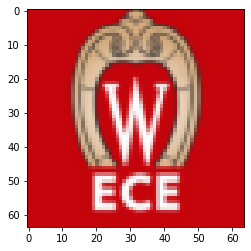

Using this uploaded matrix...
Using this uploaded matrix...
Using this uploaded matrix...
Using this uploaded matrix...
Using this uploaded matrix...
Using this uploaded matrix...
Using this uploaded matrix...
Using this uploaded matrix...
Using this uploaded matrix...
Using this uploaded matrix...
Using this uploaded matrix...
Using this uploaded matrix...
Using this uploaded matrix...
Using this uploaded matrix...
Using this uploaded matrix...
Using this uploaded matrix...
Using this uploaded matrix...
Using this uploaded matrix...
Using this uploaded matrix...
Using this uploaded matrix...
Using this uploaded matrix...
Using this uploaded matrix...
Using this uploaded matrix...
Using this uploaded matrix...
Using this uploaded matrix...
Using this uploaded matrix...
Using this uploaded matrix...
Using this uploaded matrix...
Using this uploaded matrix...
Using this uploaded matrix...
Using this uploaded matrix...
Using this uploaded matrix...
Using this uploaded matrix...
Using this

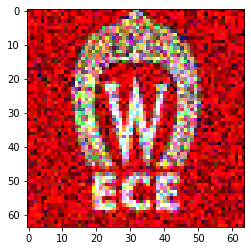

1 / 20


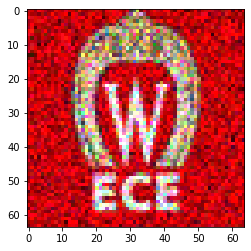

2 / 20


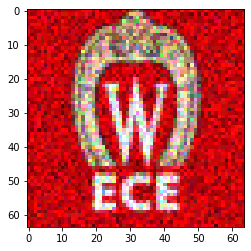

3 / 20


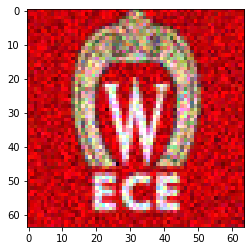

4 / 20


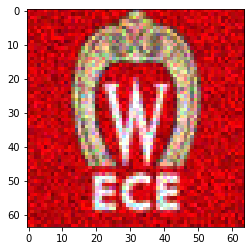

5 / 20


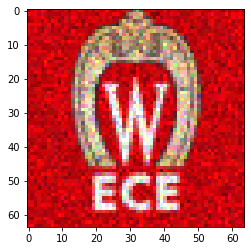

6 / 20


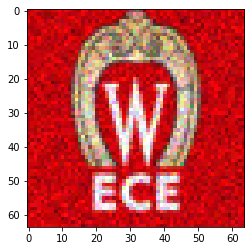

7 / 20


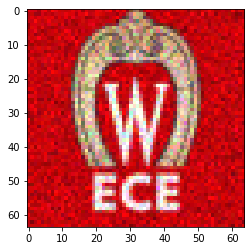

8 / 20


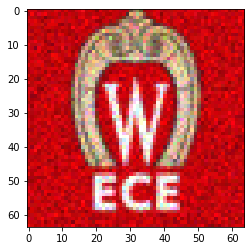

9 / 20


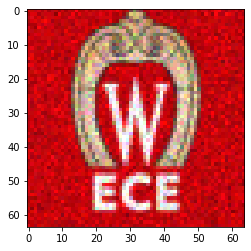

10 / 20


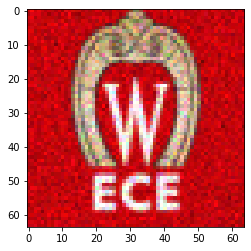

11 / 20


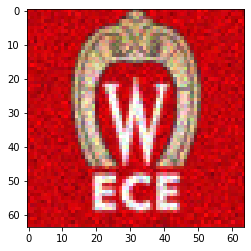

12 / 20


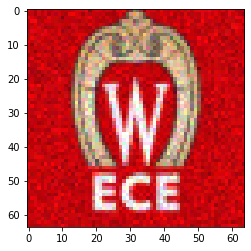

13 / 20


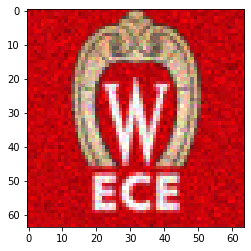

14 / 20


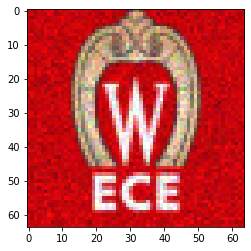

15 / 20


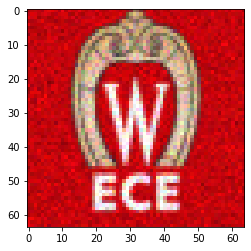

16 / 20


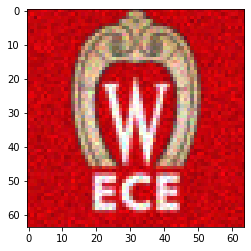

17 / 20


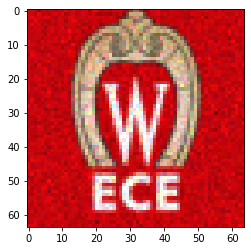

18 / 20


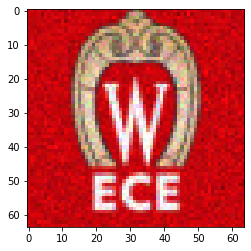

19 / 20


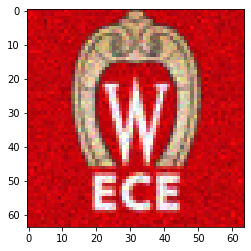

0 / 20


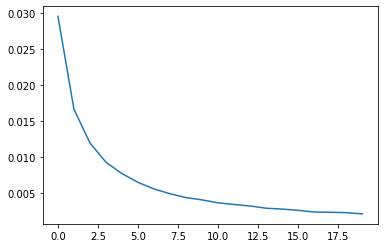

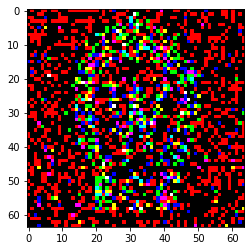

1 / 20


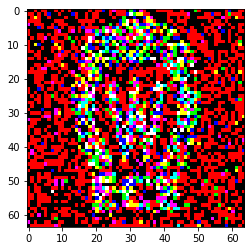

2 / 20


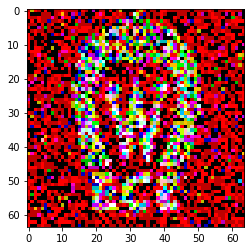

3 / 20


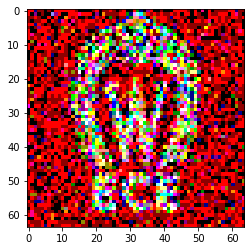

4 / 20


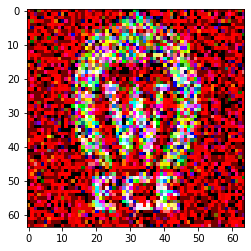

5 / 20


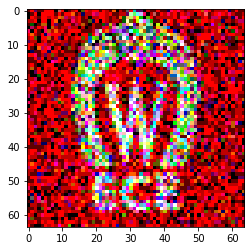

6 / 20


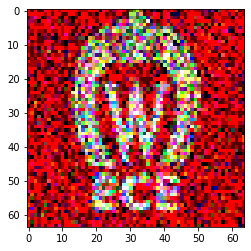

7 / 20


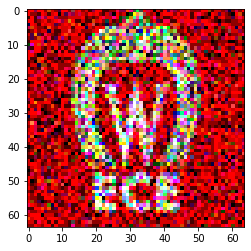

8 / 20


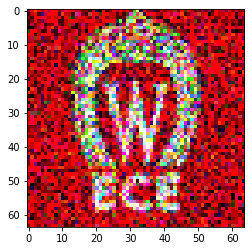

9 / 20


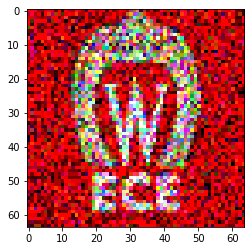

10 / 20


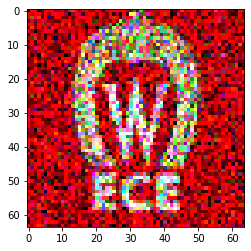

11 / 20


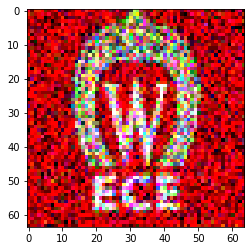

12 / 20


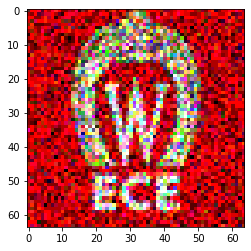

13 / 20


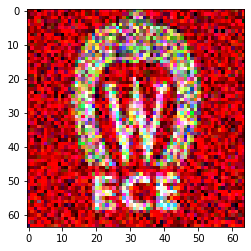

14 / 20


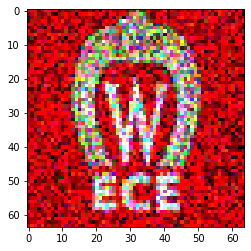

15 / 20


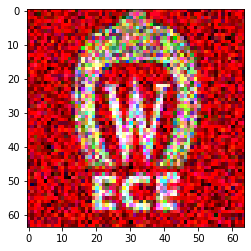

16 / 20


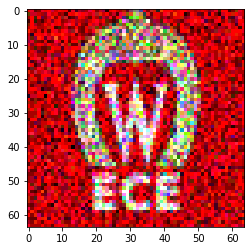

17 / 20


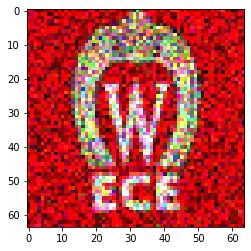

18 / 20


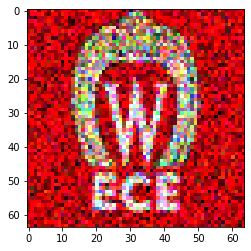

19 / 20


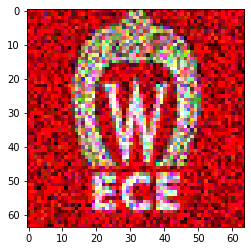

0 / 20


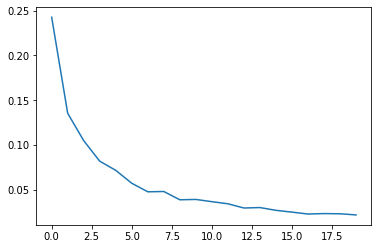

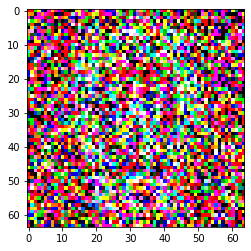

1 / 20


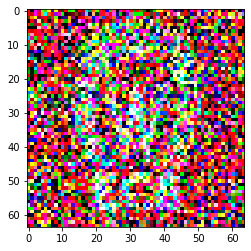

2 / 20


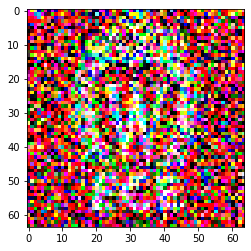

3 / 20


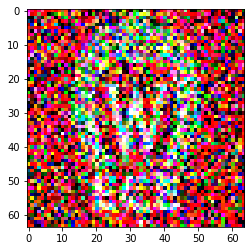

4 / 20


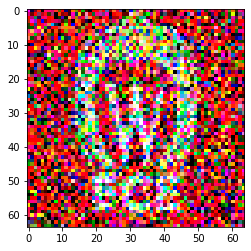

5 / 20


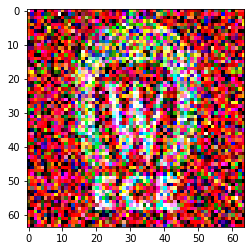

6 / 20


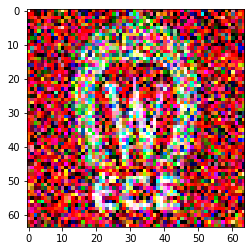

7 / 20


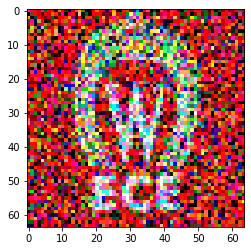

8 / 20


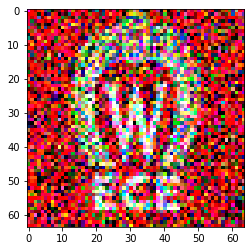

9 / 20


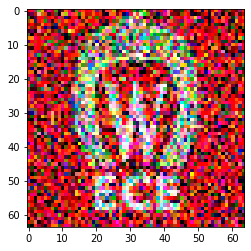

10 / 20


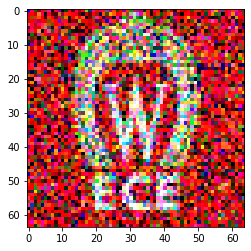

11 / 20


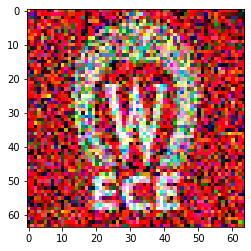

12 / 20


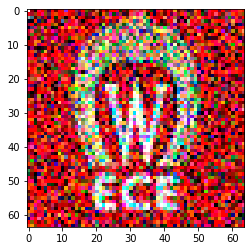

13 / 20


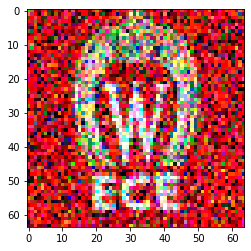

14 / 20


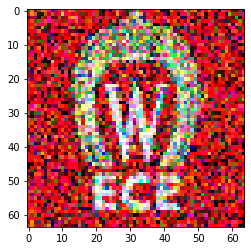

15 / 20


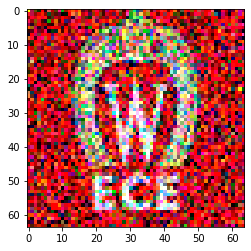

16 / 20


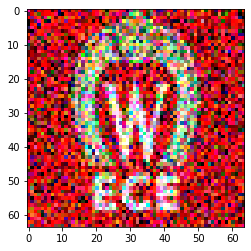

17 / 20


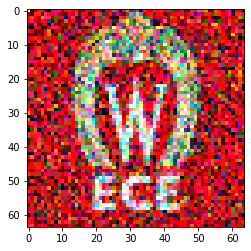

18 / 20


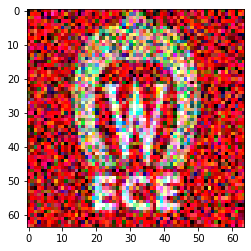

19 / 20


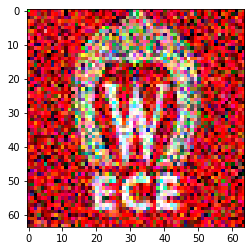

0 / 20
Mini-batch (size 10) Gradient Ascent!
cost: 2841983.217426063
cost: 0.01103987463259946
cost: 0.003685679032034173
cost: 0.0038190972770840523
cost: 0.0038717735511720544
cost: 0.003627813906804284


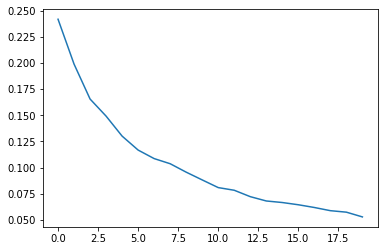

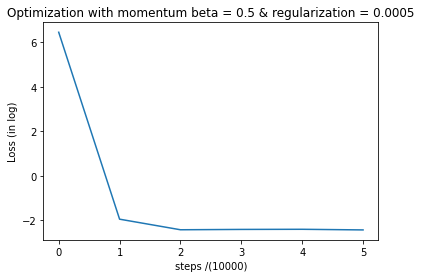

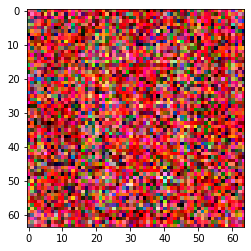

1 / 20
Mini-batch (size 10) Gradient Ascent!
cost: 2843605.326308795
cost: 0.0098909744277162
cost: 0.0037669553058033334
cost: 0.004809613506695177
cost: 0.0036498334911223627
cost: 0.004882828204727534


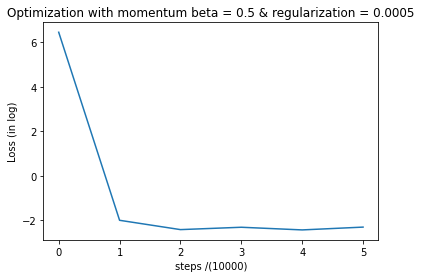

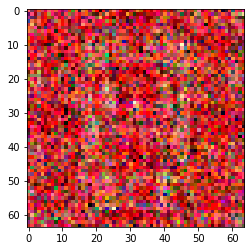

2 / 20
Mini-batch (size 10) Gradient Ascent!
cost: 2842179.318423848
cost: 0.013554408101700628
cost: 0.004506375818713573
cost: 0.0038113485448449157
cost: 0.0038639101741706583
cost: 0.0040270822501700864


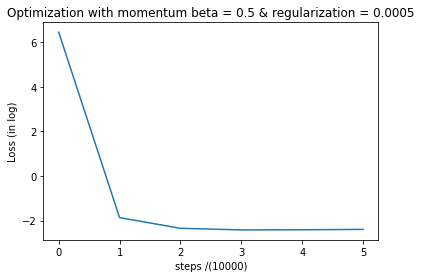

In [0]:
ratio_list = [i*0.05 for i in range(11)];
time, Error_dict = Ratio_series(ratio_list);

In [5]:
for i in range len(Error_dict):
    dic = Error_dict[i];

    plt.figure();
    for i in dic:
        plt.plot(time, dic[i], label = i);
    plt.xlabel("time/sec");
    plt.ylabel("log error");
    plt.title("Scan strategies under Poisson noise" + "ratio = " + str(ratio_list[i]));
    plt.legend(loc=[1,0]);
    plt.show();



[0.0,
 0.05,
 0.1,
 0.15000000000000002,
 0.2,
 0.25,
 0.30000000000000004,
 0.35000000000000003,
 0.4,
 0.45,
 0.5]